In [21]:
# 导入依赖模块与环境设置
# ------------------------------
from copy import deepcopy  # 深拷贝，避免修改原对象
import numpy as np         # 数值计算基础库
import torch               # PyTorch深度学习框架核心
import matplotlib.pyplot as plt  # 绘图库
import matplotlib.animation as animation  # 动画制作模块
import sys                 # 系统参数配置
from neuralop.models import otno  # 导入OTNO模型（最优传输神经算子）
from neuralop import Trainer      # 导入NeuralOP的训练器（封装训练循环）
from neuralop.training import AdamW  # AdamW优化器（带权重衰减的Adam）
from neuralop.data.datasets import load_saved_ot, CFDDataProcessor  # 数据集加载和CFD数据处理器
from neuralop.utils import count_model_params  # 统计模型参数量的工具函数
from neuralop import LpLoss  # Lp损失函数（支持L1/L2等）


In [22]:
# 加载汽车OT数据集
# ------------------------------
# 加载预生成的小型汽车CFD最优传输(OT)数据集
# 数据集结构：输入=OT映射（描述网格点的传输关系），输出=汽车表面压力场
data_module = load_saved_ot(
    n_train=2,          # 训练集样本数（2辆汽车的CFD数据）
    n_test=1,           # 测试集样本数（1辆汽车的CFD数据）
    expand_factor=3.0,  # OT网格扩展因子（控制网格分辨率）
    reg=1e-06,          # OT正则化系数（避免计算不稳定）
)

# 创建训练/测试数据加载器（批处理+打乱）
# batch_size=1：每次仅处理1个样本（适合小数据集）
train_loader = data_module.train_loader(batch_size=1, shuffle=True)  # 训练集加载器（打乱数据）
test_loader = data_module.test_loader(batch_size=1, shuffle=False)  # 测试集加载器（不打乱）

# 深拷贝输出（压力场）的归一化器，用于后续反归一化还原真实压力值
output_encoder = deepcopy(data_module.normalizers["press"])
# 创建CFD数据处理器（封装数据归一化/反归一化逻辑）
data_processor = CFDDataProcessor(normalizer=output_encoder)


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages


In [23]:
# 构建OTNO模型
# ----------------------
# OTNO（Optimal Transport Neural Operator）是专为网格数据设计的神经算子
# 核心作用：学习从OT映射到压力场的非线性映射关系
model = otno.OTNO(
    n_modes=(16, 16),               # 傅里叶模态数（控制模型表达能力，越大拟合越强但易过拟合）
    hidden_channels=64,             # 隐藏层通道数（特征维度）
    in_channels=9,                  # 输入通道数（OT映射的特征维度）
    out_channels=1,                 # 输出通道数（压力场为单通道标量）
    lifting_channel_ratio=2,        # 升维通道比例（将输入映射到更高维特征空间的比例）
    projection_channel_ratio=2,     # 降维通道比例（将高维特征映射回输出空间的比例）
    norm="group_norm",              # 归一化方式（组归一化，适合小批量训练）
    use_channel_mlp=True,           # 是否使用通道级MLP（增强通道间特征交互）
    channel_mlp_expansion=1.0,      # 通道MLP的扩展系数（控制MLP宽度）
)

# 统计并打印模型参数量（评估模型复杂度）
n_params = count_model_params(model)
print(f"\n模型总参数量: {n_params}")
sys.stdout.flush()  # 强制刷新输出缓冲区，确保信息即时打印



模型总参数量: 4787777


In [24]:
# 配置优化器和学习率调度器
# ------------------------------------
# 优化器：AdamW（带权重衰减的Adam，缓解过拟合）
# lr=1e-3：初始学习率；weight_decay=1e-4：权重衰减系数（L2正则化）
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 学习率调度器：余弦退火（CosineAnnealingLR）
# T_max=30：学习率周期（30个epoch后学习率回到初始值），此处训练15epoch仅用半个周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


In [25]:
# 定义损失函数
# -------------------------
# 使用L2损失（LpLoss中d=2表示2维数据，p=2表示L2范数）
# L2损失适合回归任务（压力场预测是连续值回归）
l2loss = LpLoss(d=2, p=2)  # d=数据维度（2D网格），p=范数阶数
train_loss_fn = l2loss  # 训练损失函数
test_loss_fn = l2loss   # 测试损失函数


In [26]:
# 打印训练配置信息
# ---------------------
# 输出模型、优化器、调度器、损失函数的关键配置，便于调试和记录
print("\n### 模型配置已经保存到OTNO_model_config.txt ###\n")
with open("OTNO_model_config.txt", "w") as f:
    print(model, file=f)
print("\n### 优化器配置 ###\n", optimizer)
print("\n### 学习率调度器 ###\n", scheduler)
print("\n### 损失函数 ###")
print(f"\n * 训练损失: {train_loss_fn}")
print(f"\n * 测试损失: {test_loss_fn}")
sys.stdout.flush()



### 模型配置已经保存到OTNO_model_config.txt ###


### 优化器配置 ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0.0001
)

### 学习率调度器 ###

### 损失函数 ###

 * 训练损失: <neuralop.losses.data_losses.LpLoss object at 0x000002341DFA75C0>

 * 测试损失: <neuralop.losses.data_losses.LpLoss object at 0x000002341DFA75C0>


In [27]:
# 创建训练器（Trainer）
# --------------------
# NeuralOP的Trainer封装了完整的训练逻辑：前向传播、损失计算、反向传播、评估、日志
trainer = Trainer(
    model=model,                    # 待训练的模型
    n_epochs=15,                    # 训练轮数（小数据集避免过拟合，仅训练15轮）
    data_processor=data_processor,  # 数据处理器（处理归一化/反归一化）
    wandb_log=False,                # 关闭Weights & Biases日志（教程简化）
    use_distributed=False,          # 关闭分布式训练（单GPU/CPU训练）
    verbose=True,                   # 打印训练过程（每轮输出损失等信息）
)


In [28]:
# 启动模型训练
# ------------------
# 训练器核心流程：
# 1. 对训练集样本执行前向传播（OTNO模型预测压力场）
# 2. 计算预测值与真实值的L2损失
# 3. 反向传播计算梯度，更新模型参数
# 4. 每轮训练后在测试集上评估模型性能
trainer.train(
    train_loader=train_loader,              # 训练数据加载器
    test_loaders={"": test_loader},        # 测试数据加载器（字典形式，支持多测试集）
    optimizer=optimizer,                   # 优化器
    scheduler=scheduler,                   # 学习率调度器（每轮更新学习率）
    training_loss=train_loss_fn,           # 训练损失函数
    eval_losses={"l2": test_loss_fn},      # 测试损失函数（字典形式，支持多损失评估）
    regularizer=None,                      # 无额外正则化（已用权重衰减）
)


Training on 2 samples
Testing on [1] samples         on resolutions [''].
Raw outputs of shape torch.Size([1, 3586])
[0] time=0.25, avg_loss=0.9841, train_err=0.9841
Eval: _l2=0.7419
[1] time=0.25, avg_loss=0.8876, train_err=0.8876
Eval: _l2=0.7068
[2] time=0.24, avg_loss=0.8141, train_err=0.8141
Eval: _l2=0.6623
[3] time=0.32, avg_loss=0.7251, train_err=0.7251
Eval: _l2=0.6132
[4] time=0.34, avg_loss=0.6147, train_err=0.6147
Eval: _l2=0.5610
[5] time=0.33, avg_loss=0.5051, train_err=0.5051
Eval: _l2=0.5345
[6] time=0.33, avg_loss=0.4244, train_err=0.4244
Eval: _l2=0.4763
[7] time=0.40, avg_loss=0.3576, train_err=0.3576
Eval: _l2=0.4506
[8] time=0.39, avg_loss=0.3181, train_err=0.3181
Eval: _l2=0.4262
[9] time=0.33, avg_loss=0.3049, train_err=0.3049
Eval: _l2=0.4416
[10] time=0.32, avg_loss=0.2669, train_err=0.2669
Eval: _l2=0.4395
[11] time=0.31, avg_loss=0.2516, train_err=0.2516
Eval: _l2=0.4078
[12] time=0.35, avg_loss=0.2474, train_err=0.2474
Eval: _l2=0.4487
[13] time=0.28, avg_lo

{'train_err': 0.21751278638839722,
 'avg_loss': 0.21751278638839722,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.23692670000036742,
 '_l2': tensor(0.4366)}

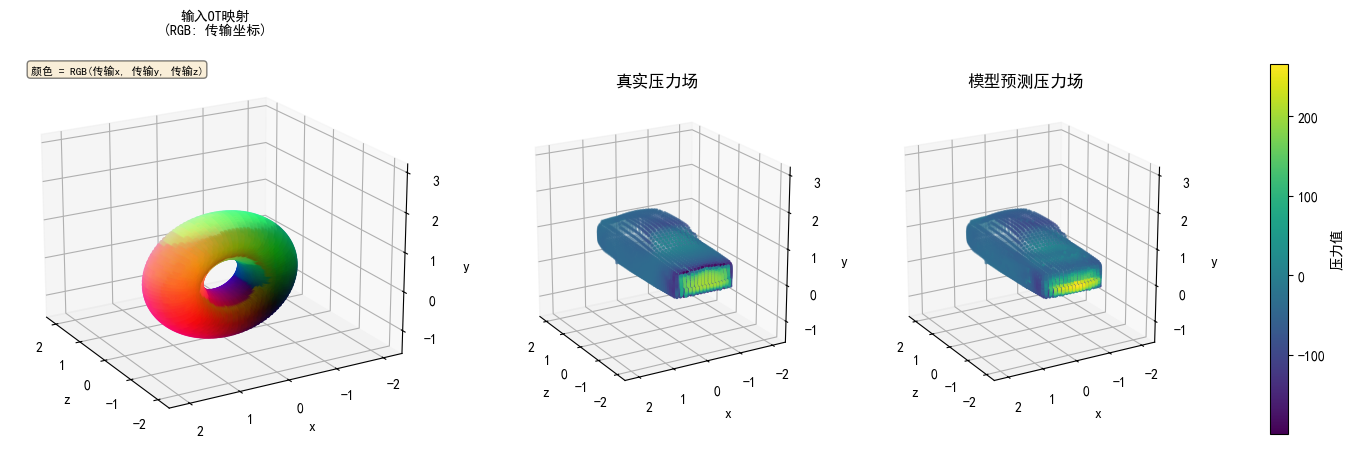


### 预测误差统计 ###
相对L2误差: 0.436600


In [29]:
# 可视化模型预测结果
# ------------------------
# 核心目标：对比「输入OT映射」「真实压力场」「模型预测压力场」
# 注意：本示例仅用2个样本训练、1个样本测试，实际应用需更大数据集保证泛化性

plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 正常显示负号

# 取测试集中第一个样本
test_sample = test_loader.dataset[0]

# 模型推理（评估模式，关闭Dropout/BatchNorm等训练特化层）
model.eval()
with torch.no_grad():  # 禁用梯度计算（节省内存，加速推理）
    # 预处理测试样本（归一化等）
    processed_sample = data_processor.preprocess(test_sample.copy())

    # 准备模型输入（添加batch维度，模型要求输入格式：[batch, channels, H, W]）
    x = processed_sample["x"].unsqueeze(0)  # x=OT映射特征，shape从[9, H, W]→[1, 9, H, W]
    ind_dec = processed_sample["ind_dec"]   # 解码索引（OT解码所需的网格索引）

    # 模型前向传播（预测压力场）
    prediction = model(x, ind_dec)

    # 反归一化：将模型输出的归一化值还原为真实压力值
    prediction = output_encoder.inverse_transform(prediction.reshape(-1, 1))
    ground_truth = output_encoder.inverse_transform(
        processed_sample["y"].reshape(-1, 1)
    )

# 提取几何数据（用于3D可视化）
vertices = test_sample["target"].numpy()  # 目标网格顶点坐标（汽车表面网格）
source = test_sample["source"].numpy()    # 源网格顶点坐标（OT的源网格）
ind_enc = test_sample["ind_enc"].numpy()  # 编码索引（OT编码所需的网格索引）
trans = vertices[ind_enc, :]              # 传输坐标（OT映射的坐标变换结果）

# 计算坐标轴范围（保证3D图比例均衡）
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
max_range = np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()]).max() / 2.0
mid_x, mid_y, mid_z = (x.max() + x.min()) * 0.5, (y.max() + y.min()) * 0.5, (z.max() + z.min()) * 0.5

# 设置压力场颜色映射的统一范围（保证真实值和预测值颜色刻度一致）
vmin = min(ground_truth.min().item(), prediction.min().item())
vmax = max(ground_truth.max().item(), prediction.max().item())

# 将传输坐标转换为RGB颜色（可视化OT映射的空间分布）
color_x = (trans[:, 0] - trans[:, 0].min()) / (trans[:, 0].max() - trans[:, 0].min())  # x坐标归一化到[0,1]
color_y = (trans[:, 1] - trans[:, 1].min()) / (trans[:, 1].max() - trans[:, 1].min())  # y坐标归一化到[0,1]
color_z = (trans[:, 2] - trans[:, 2].min()) / (trans[:, 2].max() - trans[:, 2].min())  # z坐标归一化到[0,1]
colors = np.stack([color_x, color_y, color_z], axis=1)  # 合并为RGB颜色矩阵

# 创建三列布局的3D可视化图
fig = plt.figure(figsize=(18, 6))

# 子图1：输入OT映射（RGB颜色表示传输坐标）
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
scatter1 = ax1.scatter(source[:, 0], source[:, 1], source[:, 2], c=colors, alpha=0.5, s=15)
ax1.set_xlim(mid_x - max_range, mid_x + max_range)
ax1.set_ylim(mid_y - max_range, mid_y + max_range)
ax1.set_zlim(mid_z - max_range, mid_z + max_range)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("输入OT映射\n(RGB: 传输坐标)", fontsize=10)
ax1.view_init(elev=20, azim=150, roll=0, vertical_axis="y")  # 设置3D视角
# 添加颜色说明文本框
ax1.text2D(
    0.05,
    0.95,
    "颜色 = RGB(传输x, 传输y, 传输z)",
    transform=ax1.transAxes,
    fontsize=8,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

# 子图2：真实压力场
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
scatter2 = ax2.scatter(x, y, z, s=2, c=ground_truth.cpu().numpy(), cmap="viridis", vmin=vmin, vmax=vmax)
ax2.set_xlim(mid_x - max_range, mid_x + max_range)
ax2.set_ylim(mid_y - max_range, mid_y + max_range)
ax2.set_zlim(mid_z - max_range, mid_z + max_range)
ax2.set_box_aspect([1, 1, 1])  # 强制等比例显示
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("真实压力场")
ax2.view_init(elev=20, azim=150, roll=0, vertical_axis="y")

# 子图3：模型预测压力场
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
scatter3 = ax3.scatter(x, y, z, s=2, c=prediction.cpu().numpy(), cmap="viridis", vmin=vmin, vmax=vmax)
ax3.set_xlim(mid_x - max_range, mid_x + max_range)
ax3.set_ylim(mid_y - max_range, mid_y + max_range)
ax3.set_zlim(mid_z - max_range, mid_z + max_range)
ax3.set_box_aspect([1, 1, 1])  # 强制等比例显示
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
ax3.set_title("模型预测压力场")
ax3.view_init(elev=20, azim=150, roll=0, vertical_axis="y")

# 添加颜色条（统一显示压力值刻度）
fig.colorbar(scatter2, ax=[ax2, ax3], pad=0.1, label="压力值", shrink=0.8)

# 显示可视化图
plt.show()

# 打印预测误差统计（相对L2误差：衡量预测精度，越小越好）
print(f"\n### 预测误差统计 ###")
relative_l2_error = (torch.norm(prediction - ground_truth) / torch.norm(ground_truth)).item()
print(f"相对L2误差: {relative_l2_error:.6f}")


生成汽车→环面编码动画...
生成环面→汽车解码动画（带压力场）...


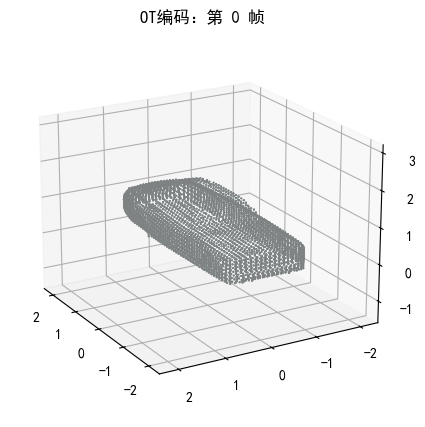

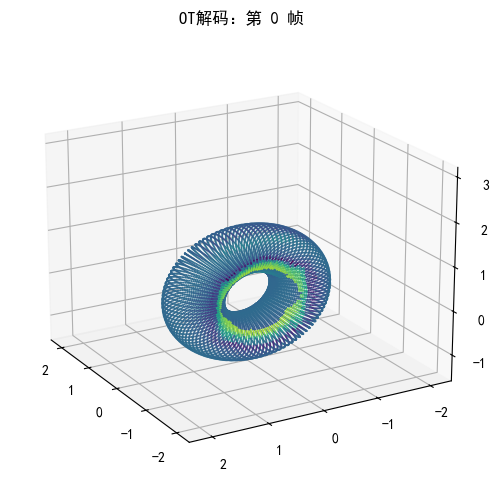

In [30]:
# 可视化OT编码和解码过程（动画）
# -------------------------------------
# 动画展示：
# 1. 编码：汽车表面网格 → 隐式环面网格（OT Encoding）
# 2. 解码：隐式环面网格 → 汽车表面网格（OT Decoding）

# 提取压力场的拉回值（用于解码动画的颜色映射）
pressure_pullback = ground_truth[ind_enc].numpy()
n_s = source.shape[0]  # 源网格点数量

# ----------------------
# 1. OT编码动画（汽车→环面）
# ----------------------
T = 60  # 动画总帧数
movement_enc = np.zeros((T, n_s, 3))  # 存储每一帧的网格点坐标

for j in range(n_s):
    # 线性插值：从汽车表面坐标(trans)到环面坐标(source)
    tx = np.linspace(trans[j, 0], source[j, 0], T).reshape((T, 1))
    ty = np.linspace(trans[j, 1], source[j, 1], T).reshape((T, 1))
    tz = np.linspace(trans[j, 2], source[j, 2], T).reshape((T, 1))
    movement_enc[:, j, :] = np.concatenate((tx, ty, tz), axis=1)

# 创建编码动画的3D图
print("生成汽车→环面编码动画...")
fig_enc = plt.figure(figsize=(5, 5))
ax_enc = fig_enc.add_subplot(111, projection="3d")
# 初始化散点图（第一帧）
sc_enc = ax_enc.scatter(
    movement_enc[0, :, 0],
    movement_enc[0, :, 1],
    movement_enc[0, :, 2],
    c="grey",
    s=2,
    alpha=0.95,
    edgecolors="#7fb0b6",
    linewidths=0.03,
    depthshade=True,
)
ax_enc.set_xlim(mid_x - max_range, mid_x + max_range)
ax_enc.set_ylim(mid_y - max_range, mid_y + max_range)
ax_enc.set_zlim(mid_z - max_range, mid_z + max_range)
ax_enc.set_title("OT编码：汽车表面 → 隐式环面")
ax_enc.view_init(elev=20, azim=150, roll=0, vertical_axis="y")

# 动画更新函数（逐帧更新坐标）
def update_enc(frame):
    xs = movement_enc[frame, :, 0]
    ys = movement_enc[frame, :, 1]
    zs = movement_enc[frame, :, 2]
    sc_enc._offsets3d = (xs, ys, zs)  # 更新3D散点坐标
    ax_enc.set_title(f"OT编码：第 {frame} 帧")
    return (sc_enc,)

# 创建编码动画（interval=50：每帧间隔50ms）
ani_enc = animation.FuncAnimation(
    fig_enc, update_enc, frames=T, interval=50, blit=False
)

# ----------------------
# 2. OT解码动画（环面→汽车）
# ----------------------
T = 60  # 动画总帧数
movement_dec = np.zeros((T, n_s, 3))  # 存储每一帧的网格点坐标

for j in range(n_s):
    # 线性插值：从环面坐标(source)到汽车表面坐标(trans)
    tx = np.linspace(source[j, 0], trans[j, 0], T).reshape((T, 1))
    ty = np.linspace(source[j, 1], trans[j, 1], T).reshape((T, 1))
    tz = np.linspace(source[j, 2], trans[j, 2], T).reshape((T, 1))
    movement_dec[:, j, :] = np.concatenate((tx, ty, tz), axis=1)

# 创建解码动画的3D图（带压力场颜色）
print("生成环面→汽车解码动画（带压力场）...")
fig_dec = plt.figure(figsize=(8, 6))
ax_dec = fig_dec.add_subplot(111, projection="3d")
# 初始化散点图（第一帧）
sc_dec = ax_dec.scatter(
    movement_dec[0, :, 0],
    movement_dec[0, :, 1],
    movement_dec[0, :, 2],
    c=pressure_pullback,
    cmap="viridis",
    s=2,
    vmin=vmin,
    vmax=vmax,
    alpha=0.95,
    edgecolors="none",
    linewidths=0.03,
    depthshade=True,
)
ax_dec.set_xlim(mid_x - max_range, mid_x + max_range)
ax_dec.set_ylim(mid_y - max_range, mid_y + max_range)
ax_dec.set_zlim(mid_z - max_range, mid_z + max_range)
ax_dec.set_title("OT解码：隐式环面 → 汽车表面（压力场）")
ax_dec.view_init(elev=20, azim=150, roll=0, vertical_axis="y")

# 动画更新函数（逐帧更新坐标）
def update_dec(frame):
    xs = movement_dec[frame, :, 0]
    ys = movement_dec[frame, :, 1]
    zs = movement_dec[frame, :, 2]
    sc_dec._offsets3d = (xs, ys, zs)  # 更新3D散点坐标
    ax_dec.set_title(f"OT解码：第 {frame} 帧")
    return (sc_dec,)

# 创建解码动画
ani_dec = animation.FuncAnimation(
    fig_dec, update_dec, frames=T, interval=50, blit=False
)

# 若需保存动画，可添加以下代码（需安装ffmpeg）
ani_enc.save("ot_encoding.gif", writer='pillow', fps=10)
ani_dec.save("ot_decoding.gif", writer='pillow', fps=10)